In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# SIMS 

In [ ]:
# block rewards + MEV rewards 
# selfish, beta-execution, beta-both

In [369]:
# SELFISH
def simSelfish(alpha, gamma=0, total=int(1e5)):
    curState = 0
    selfishBlocks = 0
    otherBlocks = 0
    for _ in range(total):
        flip = np.random.uniform()
        if curState == 0:
            if flip < alpha:
                curState = 1
            else: otherBlocks += 1
#         elif curState == 'double':
#             if flip < alpha:
#                 selfishBlocks += 1
#             else: otherBlocks += 1
#             curState = 0
        elif curState == 'single':
            if flip < alpha:
                selfishBlocks += 2
            elif flip < alpha + gamma * (1-alpha):
                selfishBlocks += 1
                otherBlocks += 1
            else:
                otherBlocks += 2
            curState = 0
        elif curState == 1:
            if flip < alpha:
                curState = 2
            else: curState = 'single'
        elif curState == 2:
            if flip < alpha:
                selfishBlocks += 1
                curState = 3
            else:
                selfishBlocks += 2
#                 curState = 'double'
                curState = 0
        else:
            if flip < alpha:
                selfishBlocks += 1
                curState += 1
            else:
                curState -= 1
    if curState not in [0, 'single', 'double']:
        selfishBlocks += curState
    return selfishBlocks/(selfishBlocks+otherBlocks)

In [370]:
def selfishRewardEyal(a, gamma):
    num = a * np.power(1-a, 2) * (4*a + gamma*(1-2*a)) - np.power(a,3)
    den = 1 - a * (1 + (2-a)*a)
    return num/den

def selfishRewardCarlsten(a, gamma):
    num = 5*a**2 - 12*a**3 + 9*a**4 - 2*a**5 + gamma * (a - 4*a**2 + 6*a**3 - 5*a**4 + 2*a**5)
    den = 2*a**3 - 4*a**2 + 1
    return num / den

def selfishRewardSim(a, gamma):
    res = []
    for _ in range(10):
        res.append(simSelfish(a, gamma))
    return np.mean(res)

In [375]:
selfishReward(.2, gamma=0.), simSelfish(0.2, gamma=0.)

(0.1296703296703297, 0.1262357057317961)

In [376]:
alphas = np.arange(0.001, 0.50, 0.001)
wRes, eRes = [], []
simRes = []
for g in [0, 0.5, 1]:
    wRes.append(selfishRewardCarlsten(alphas, g))
    eRes.append(selfishRewardEyal(alphas, g))
wRes = np.array(wRes)
eRes = np.array(eRes)

simRes = []
simAlphas = np.arange(0.01, 0.5, 0.01)
for g in [0, 0.5, 1]:
    temp = []
    for alpha in tqdm(simAlphas):
        temp.append(selfishRewardSim(alpha, g))
    simRes.append(temp)
simRes = np.array(simRes)

wRes.shape, eRes.shape, simRes.shape

100%|██████████| 49/49 [01:51<00:00,  2.27s/it]


((3, 499), (3, 499), (3, 49))

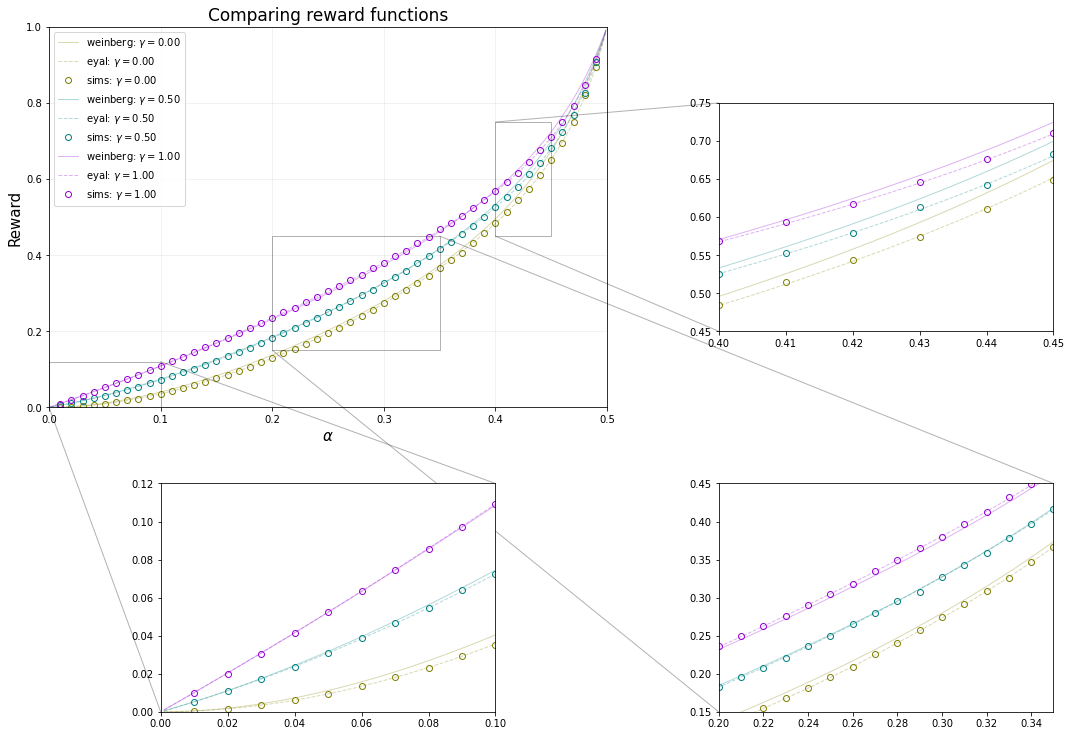

In [379]:
f, ax = plt.subplots(figsize=(10,7))

axins0 = ax.inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0., 0.1), ylim=(0., .12))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.4, 0.45), ylim=(0.45, 0.75))
axins2 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.2, 0.35), ylim=(0.15, 0.45))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)


colors = ['olive', 'teal', 'darkviolet']
for i, g in enumerate([0, 0.5, 1]):
    for a in [ax, axins0, axins1, axins2]:
        a.plot(alphas, wRes[i], linewidth=1, color=colors[i], label=r'weinberg: $\gamma={:0.2f}$'.format(g),
               alpha=0.3)
        a.plot(alphas, eRes[i], linewidth=1, color=colors[i], label=r'eyal: $\gamma={:0.2f}$'.format(g),
                linestyle='--', alpha=0.3)
        
        a.plot(simAlphas, simRes[i], marker='o', fillstyle='none', linewidth=0, 
                label='sims: $\gamma={:0.2f}$'.format(g), color=colors[i])
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Reward', size=15)
ax.set_title(r'Comparing reward functions', size=17)

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)
ax.grid(alpha=0.2)
ax.legend(loc=2)
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [78]:
flip = np.random.uniform()
flip

0.11023413689558892

# p1 calculation

In [10]:
a, b, d, p1 = sp.symbols('alpha beta delta p_1')

p0   = p1/(a*(1-1/b**d))
p0p  = (1-a)*p1
p0dp = a*p1
p2p  = p1*(1-a)*a/((a-1)*(2*a-1))

eq = sp.Eq(p0 + p0p + p0dp + p1 + p2p, 1)
sol = sp.solve(eq, p1)

In [15]:
p0

p_1/(alpha*(1 - 1/beta**delta))

In [14]:
sol[0]

alpha*(2*alpha*beta**delta - 2*alpha - beta**delta + 1)/(3*alpha**2*beta**delta - 3*alpha**2 + 2*alpha - beta**delta)

In [56]:
p1 = sol[0].evalf(subs={d:2})
p1

alpha*(2.0*alpha*beta**2 - 2.0*alpha - beta**2 + 1.0)/(3.0*alpha**2*beta**2 - 3.0*alpha**2 + 2.0*alpha - beta**2)

# f0p0

In [53]:
x, d, b = sp.symbols('x delta beta')
sp.integrate(1/x**2, (x, b, sp.oo))
# sp.integrate(1/x**d, (x))

1/beta

In [64]:
x, d, b, a, g = sp.symbols('x delta beta alpha gamma')

expr = (1/x**d) * ((1/(b+x)**d) + a**2*(1-1/(b+x)**d) + a*(1-a)*(a+(1-a)*g)*(1-1/(b+x)**d))
sp.expand(expr)

alpha**3*gamma/x**delta - alpha**3*gamma/(x**delta*(beta + x)**delta) - alpha**3/x**delta + alpha**3/(x**delta*(beta + x)**delta) - 2*alpha**2*gamma/x**delta + 2*alpha**2*gamma/(x**delta*(beta + x)**delta) + 2*alpha**2/x**delta - 2*alpha**2/(x**delta*(beta + x)**delta) + alpha*gamma/x**delta - alpha*gamma/(x**delta*(beta + x)**delta) + 1/(x**delta*(beta + x)**delta)

In [69]:
expanded = sp.expand(expr).evalf(subs={d:3})
expanded

alpha**3*gamma/x**3 - alpha**3*gamma/(x**3*(beta + x)**3) - alpha**3/x**3 + alpha**3/(x**3*(beta + x)**3) - 2.0*alpha**2*gamma/x**3 + 2.0*alpha**2*gamma/(x**3*(beta + x)**3) + 2.0*alpha**2/x**3 - 2.0*alpha**2/(x**3*(beta + x)**3) + alpha*gamma/x**3 - alpha*gamma/(x**3*(beta + x)**3) + 1/(x**3*(beta + x)**3)

In [70]:
out = sp.integrate(expanded, (x, 0, b))
out

KeyboardInterrupt: 

In [60]:
print_latex(sp.simplify(out))

\begin{cases} \text{NaN} & \text{for}\: \frac{\alpha^{3} \beta^{2} \gamma - \alpha^{3} \beta^{2} - \alpha^{3} \gamma + \alpha^{3} - 2 \alpha^{2} \beta^{2} \gamma + 2 \alpha^{2} \beta^{2} + 2 \alpha^{2} \gamma - 2 \alpha^{2} + \alpha \beta^{2} \gamma - \alpha \gamma + 1}{\beta^{2}} = 0 \\\frac{\infty \beta \left(\alpha^{3} \beta^{2} \gamma - \alpha^{3} \beta^{2} - \alpha^{3} \gamma + \alpha^{3} - 2 \alpha^{2} \beta^{2} \gamma + 2 \alpha^{2} \beta^{2} + 2 \alpha^{2} \gamma - 2 \alpha^{2} + \alpha \beta^{2} \gamma - \alpha \gamma + 1\right) - 1.0 \cdot \left(1.0 \alpha^{3} \beta^{2} \gamma - 1.0 \alpha^{3} \beta^{2} - 0.113705638880109 \alpha^{3} \gamma + 0.113705638880109 \alpha^{3} - 2.0 \alpha^{2} \beta^{2} \gamma + 2.0 \alpha^{2} \beta^{2} + 0.227411277760219 \alpha^{2} \gamma - 0.227411277760219 \alpha^{2} + 1.0 \alpha \beta^{2} \gamma - 0.113705638880109 \alpha \gamma + 0.113705638880109\right) \left|{\frac{\alpha^{3} \beta^{2} \gamma - \alpha^{3} \beta^{2} - \alpha^{3} \gamma + \al

In [61]:
total = sp.simplify((out + 2*a**2/(1-2*a)+3*a-a**2)*p1)
total

nan

In [62]:
total

nan

In [ ]:
# R_f general
a, b, g = sp.symbols('alpha beta gamma')

A_expr = a * (sp.exp(-b) / (a*(1-sp.exp(-b))) + 2 - a + ((2-a)/(1-a)) + ((((1-a)**2)*g)/a) + (a**2/((1-2*a)*(1-a))))
H_expr = (1-a) / (a*(1-sp.exp(-b))) + ((1-a)**2)*(2-g) + a*(1-a)

R_f = A_expr / (A_expr + H_expr)

simplified_Rf = sp.simplify(R_f)
simplified_Rf